# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [2]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
#from keras.models import load_model
#from keras.models import model_from_json

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools
import time

In [3]:
# To determine % of files that contain teh hero:
# (From: https://udacity-robotics.slack.com/files/U4UKR0C5Q/F7DTF3D1C/Script_to_see_what___of_training_image_masks_contain_the_hero.py)
#By tokyo_adam 4-10-17 
import cv2
import numpy as np
import glob, os

#set to the directory where your masks are saved
print ("Current dir: ", os.getcwd())
img_dir = "../data/masks/train/set0"

total_files = 0
total_hero = 0

#os.chdir(img_dir)
files = glob.glob(os.path.join(img_dir, 'masks', "*.png"))
print ("Files found: ", len(files))
if (len(files) > 0):
    for file in files:
        total_files +=1

        img = cv2.imread(file)
        blue = img[:,:,0]

        if np.any(blue == 255):
            total_hero += 1
    percent_hero = 100. * total_hero / total_files
    print (percent_hero, "percent of files containing the hero")
else:
    print ("No files found in folder: ", img_dir)

Current dir:  /home/ubuntu/projects/RoboND-FollowMe/code
Files found:  4131
37.64221738077947 percent of files containing the hero


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [4]:
def separable_conv2d_batchnorm(input_layer, filters, kernel_size, strides, name="sep-convolution-w-batchnorm"):
    with tf.name_scope(name):
        output_layer = SeparableConv2DKeras(filters=filters,kernel_size=kernel_size, strides=strides,
                                            padding='same', activation='relu'
                                            #, name='separable-conv-layer'
                                            )(input_layer)

        output_layer = layers.BatchNormalization(
                                                #name="batch-normalization-layer"
                                                )(output_layer)
        return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size, strides, name="convolution-w-batchnorm"):
    with tf.name_scope(name):
        output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                                     padding='same', activation='relu'
                                     #, name='convolution-layer'
                                    )(input_layer)

        output_layer = layers.BatchNormalization(
                                                #name="batch-normalization-layer"
                                                )(output_layer)
        return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [5]:
def bilinear_upsample(input_layer, multiplier, name="bi-upsample"):
    with tf.name_scope(name):
        output_layer = BilinearUpSampling2D((multiplier, multiplier)
                                            #, name="upsampler-layer"
                                           )(input_layer)
#         tf.summary.histogram('weights', output_layer.get_weights()[0])
#         tf.summary.histogram('biases', output_layer.get_weights()[1])
#         tf.summary.histogram('biases', output_layer.output)
        return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [6]:
def encoder_block(input_layer, filters, kernel_size, strides, name="encoder-block"):
    with tf.name_scope(name):
        # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
        output_layer = separable_conv2d_batchnorm(input_layer, filters, kernel_size=kernel_size, strides=strides, name="separable-convolution-block")
        return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [7]:
def decoder_block(small_ip_layer, large_ip_layer, filters, multiplier, kernel_size, name="decoder-block"):
    
    with tf.name_scope(name):
        # TODO Upsample the small input layer using the bilinear_upsample() function.
        upsampled_layer = bilinear_upsample(small_ip_layer, multiplier=multiplier, name='upsample-block')

        # TODO Concatenate the upsampled and large input layers using layers.concatenate
        layer = layers.concatenate([upsampled_layer, large_ip_layer]
                                   #, name='concatenate-1'
                                  )
        print ("Concatenating: {} + {} = {}".format(upsampled_layer.get_shape(), large_ip_layer.get_shape(), layer.get_shape()))

        # TODO Add some number of separable convolution layers
        layer = separable_conv2d_batchnorm(layer, filters, kernel_size=kernel_size, strides=1
                                           #, name="separable-convolution-block-1"
                                          )
        layer = separable_conv2d_batchnorm(layer, filters, kernel_size=kernel_size, strides=1
                                           #, name="separable-convolution-block-2"
                                          )
        layer = separable_conv2d_batchnorm(layer, filters, kernel_size=kernel_size, strides=1
                                           #, name="separable-convolution-block-2"
                                          )

        return layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
def fcn_model(inputs, num_classes):
    
    print("Input: {}".format(inputs.get_shape()))
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    with tf.name_scope("model"):
        layer = conv_1 = encoder_block(inputs, filters=32, kernel_size=3, strides=2, name='encoder-block-1')
        print("Conv1: {}".format(layer.get_shape()))
        layer = conv_2 = encoder_block(layer, filters=64, kernel_size=3, strides=2, name='encoder-block-2')
        print("Conv2: {}".format(layer.get_shape()))
        layer = conv_3 = encoder_block(layer, filters=128, kernel_size=3, strides=2, name='encoder-block-3')
        print("Conv3: {}".format(layer.get_shape()))
        layer = conv_4 = encoder_block(layer, filters=256, kernel_size=3, strides=2, name='encoder-block-4')
        print("Conv4: {}".format(layer.get_shape()))
        layer = conv_5 = encoder_block(layer, filters=512, kernel_size=3, strides=2, name='encoder-block-5')
        print("Conv5: {}".format(layer.get_shape()))

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
        layer = conv_6 = conv2d_batchnorm(layer, filters=512, kernel_size=1, strides=1, name='1x1-convolution')
        print("1x1: {}".format(layer.get_shape()))
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
        layer = conv_7 = decoder_block(layer, conv_4, filters=256, multiplier=2, kernel_size=3, name='decoder-block-5')
        print("Conv7: {}".format(layer.get_shape()))
        layer = conv_8 = decoder_block(layer, conv_3, filters=128, multiplier=2, kernel_size=3, name='decoder-block-4')
        print("Conv8: {}".format(layer.get_shape()))
        layer = conv_9 = decoder_block(layer, conv_2, filters=64, multiplier=2, kernel_size=3, name='decoder-block-3')
        print("Conv9: {}".format(layer.get_shape()))
        layer = conv_10 = decoder_block(layer, conv_1, filters=32, multiplier=2, kernel_size=3, name='decoder-block-2')
        print("Conv10: {}".format(layer.get_shape()))
        layer = conv_11 = decoder_block(layer, inputs, filters=16, multiplier=2, kernel_size=3, name='decoder-block-1')
        print("Conv11: {}".format(layer.get_shape()))
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
        layer = output_layer = layers.Conv2D(filters=num_classes, kernel_size=3, strides=1, activation='softmax', padding='same', name='output-layer')(layer)
#         tf.summary.histogram('weights', output_layer.get_weights()[0])
#         tf.summary.histogram('biases', output_layer.get_weights()[1])
#         tf.summary.histogram('biases', output_layer.output)
        print ("Output: {}".format(layer.get_shape()))
        return output_layer

### Data Augmentation
This section defines two data augmentation methods:
- do_filter(): To filter out image+mask tuples that do not satisfy a criteria. A 'True' return value drops the item from consideration. 'False' retains the tuple.
- do_preprocess(): To perform any modification to the image and/or mask, such as vertical flip, etc.

In [9]:
# To filter out any image files that do not satisfy certain criteria (DURING TRAINING ONLY)
def do_filter(image_path, mask_path):
    contains_hero = misc.imread(mask_path)[:,:,0].max() == 255
    if not contains_hero:
        r = random.uniform(0, 1)
        if r > 0.30:
            return False # We process only 70% of images without the hero
        else:
            return True

    # If hero exists, we always accept by returning False
    return False

# To modify the image and mask before they are used for training (DURING TRAINING ONLY)
import random
import cv2

def do_preprocess(image, mask):
    r = random.uniform(0, 1)
    if r > 0.50:
#        print ("x", end="")
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)
#    else:
#        print (".", end="")
    return image, mask

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **batches_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **batches_per_validation**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except batches_per_validation is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
# This class is tracked at each training invocation
# Any data point that affects the training outcome should go here
class T (object):
    # Static
    image_hw = 160
    image_shape = (image_hw, image_hw, 3)
    num_classes = 3
    
    # Changing
    learning_rate = 0.001
    batch_size = 32 # 200,
    num_epochs = 200
    batches_per_epoch = 130 #200
    batches_per_validation = 25 # 50
    workers = 1
    train_set_names = ['set0']
    validation_set_names = ['set0']
    weights_file_name = 'weights.hd5'
    arch_file_name = 'architecture.json'
    reload_weights = True
    skip_training = True
    dry_run = False
    patience = 25

#class Trackables(object):
#  def __init__(self, adict):
#    self.__dict__.update(adict)


## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Defining the input and output layers:
inputs = layers.Input(T.image_shape)
output_layer = fcn_model(inputs, T.num_classes)

Input: (?, 160, 160, 3)
Conv1: (?, 80, 80, 32)
Conv2: (?, 40, 40, 64)
Conv3: (?, 20, 20, 128)
Conv4: (?, 10, 10, 256)
Conv5: (?, 5, 5, 512)
1x1: (?, 5, 5, 512)
Concatenating: (?, 10, 10, 512) + (?, 10, 10, 256) = (?, 10, 10, 768)
Conv7: (?, 10, 10, 256)
Concatenating: (?, 20, 20, 256) + (?, 20, 20, 128) = (?, 20, 20, 384)
Conv8: (?, 20, 20, 128)
Concatenating: (?, 40, 40, 128) + (?, 40, 40, 64) = (?, 40, 40, 192)
Conv9: (?, 40, 40, 64)
Concatenating: (?, 80, 80, 64) + (?, 80, 80, 32) = (?, 80, 80, 96)
Conv10: (?, 80, 80, 32)
Concatenating: (?, 160, 160, 32) + (?, 160, 160, 3) = (?, 160, 160, 35)
Conv11: (?, 160, 160, 16)
Output: (?, 160, 160, 3)


In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import json

# sess = tf.Session()
# writer = tf.summary.FileWriter('../logs')
# writer.add_graph(sess.graph)

# Define the Keras model and compile it for training
arch_file_path = os.path.join("../data/weights/", T.arch_file_name)
weights_file_path = os.path.join("../data/weights/", T.weights_file_name)
model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(T.learning_rate), loss='categorical_crossentropy') # lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
if T.reload_weights and os.path.isfile(weights_file_path):
    print ("Continuing training from existing model file:", arch_file_path)
    model.load_weights(weights_file_path)
else:
    print ("Building model from a clean slate...")

if not T.skip_training:
    ############################
    # Data iterators for loading the training and validation data
    ############################
    train_data_folders = []
    for name in T.train_set_names:
        train_data_folders.append(os.path.join('..', 'data', 'masks', 'train', name))
    print ("Training data: {}".format(train_data_folders))
    train_iter = data_iterator.BatchIteratorSimple(batch_size=T.batch_size,
                                                   data_folders=train_data_folders,
                                                   image_shape=T.image_shape,
                                                   shift_aug=True,
                                                   filter_callback = do_filter,
                                                   preprocess_callback = do_preprocess)
    validation_data_folders = []
    for name in T.validation_set_names:
        validation_data_folders.append(os.path.join('..', 'data', 'masks', 'validation', name))
    val_iter = data_iterator.BatchIteratorSimple(batch_size=T.batch_size,
                                                 data_folders=validation_data_folders,
                                                 image_shape=T.image_shape)

    # Setting up some callbacks
    callbacks = []
    callbacks.append(keras.callbacks.TensorBoard(log_dir='../logs'
#                                                  , histogram_freq=1, \
#                                                 write_graph=True, \
#                                                 write_grads=True, \
#                                                 batch_size=T.batch_size, \
#                                                 write_images=True)
                                                )
                    )
    callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=T.patience, verbose=1, mode='min'))

    ############################
    # History:
    ############################
    history_folder = os.path.join('../data/weights/history', time.strftime('%d_%m_%Y_%H_%M_%S'))
    if not os.path.exists(history_folder):
        os.makedirs(history_folder)

    # Hyperperamaters tracking for history
    with open(os.path.join(history_folder, "T.txt"), "w+") as T_file:
        T_file.write("{}".format(vars(T)))

    # Weights checkpoints for history
    callbacks.append(keras.callbacks.ModelCheckpoint(os.path.join(history_folder, '{epoch:02d}-weights-val_loss({val_loss:.4f}).h5'), 
                                                     monitor='val_loss', 
                                                     save_weights_only = True,
                                                     verbose=1, 
                                                     period=1))

    # Val_loss tracking and model architecture checkpoints for history:
    callbacks.append(plotting_tools.LoggerPlotter(model, 
                                                  arch_file_path=os.path.join(history_folder, T.arch_file_name),
                                                  image_path_template=os.path.join(history_folder, "{:02d}-val-loss-history-plot.png")))

    ############################
    # Optimal model tracking:
    ############################
    if not T.dry_run:
        callbacks.append(keras.callbacks.ModelCheckpoint(weights_file_path, 
                                                         monitor='val_loss', 
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         mode='auto',
                                                         verbose=1, 
                                                         period=1))

        # Also save the architecture
        model_arch_json = model.to_json()
        with open(arch_file_path, "w+") as arch_file:
            json.dump(model_arch_json, arch_file)

    ############################
    # Training:
    ############################
    model.fit_generator(train_iter,
                        steps_per_epoch = T.batches_per_epoch, # the number of batches per epoch,
                        epochs = T.num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = T.batches_per_validation, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = T.workers)

Continuing training from existing model file: ../data/weights/architecture.json


In [13]:
# Save your trained model weights
# model_tools.save_network(model, T.weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [14]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.
# model = model_tools.load_network(T.weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [15]:
run_num = 'run_1'
val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        'test', 'patrol_with_targ', run_num) 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        'test', 'patrol_non_targ', run_num) 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        'test', 'following_images', run_num)

# files being inferred: 322
	../data/masks/test/patrol_with_targ -> ../data/inferences/patrol_with_targ_run_1
# files being inferred: 270
	../data/masks/test/patrol_non_targ -> ../data/inferences/patrol_non_targ_run_1
# files being inferred: 542
	../data/masks/test/following_images -> ../data/inferences/following_images_run_1


Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

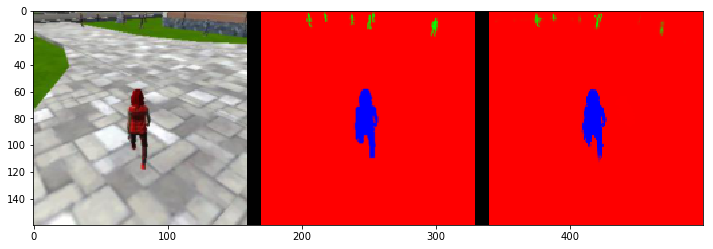

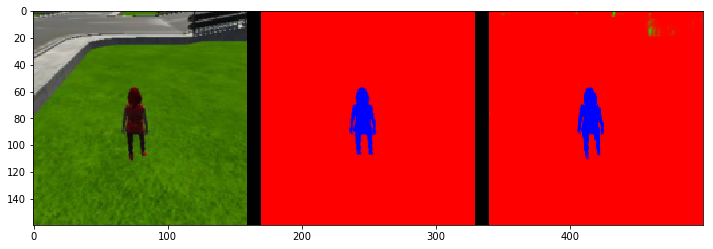

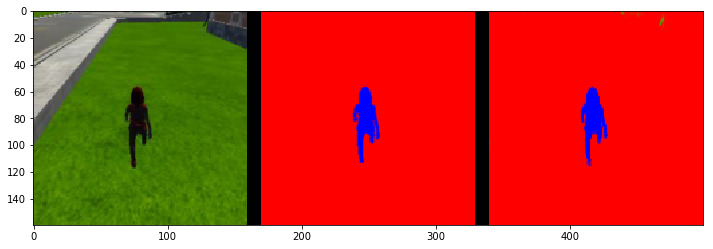

In [16]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('test', 'following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

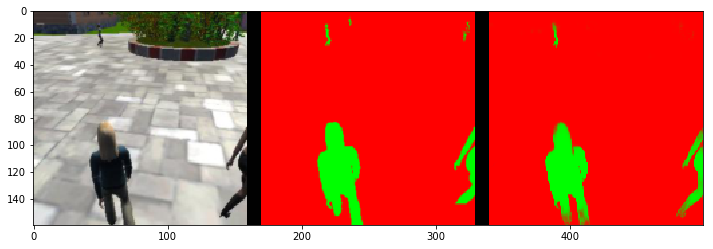

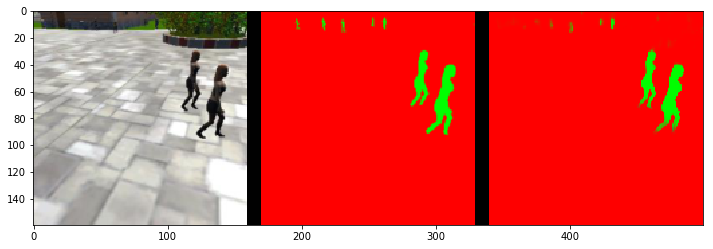

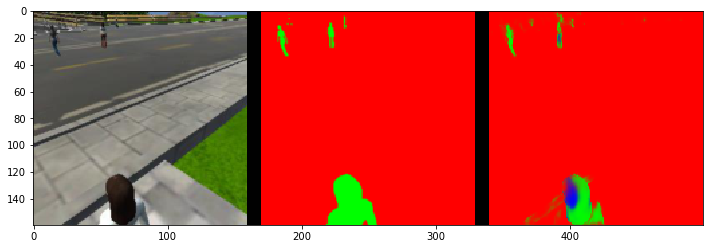

In [17]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('test', 'patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

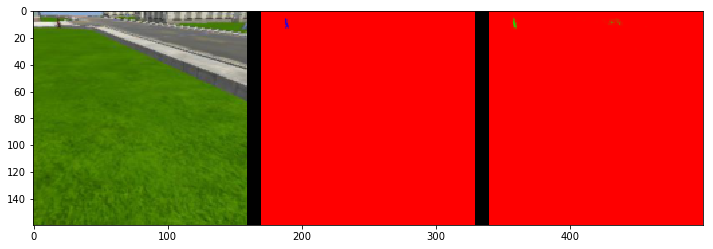

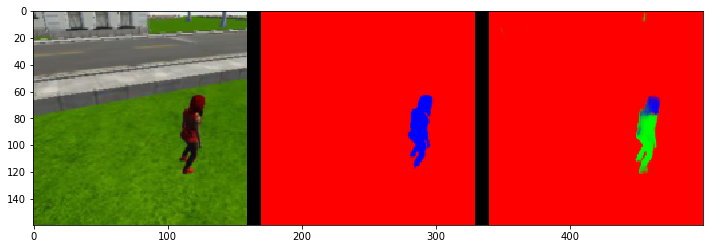

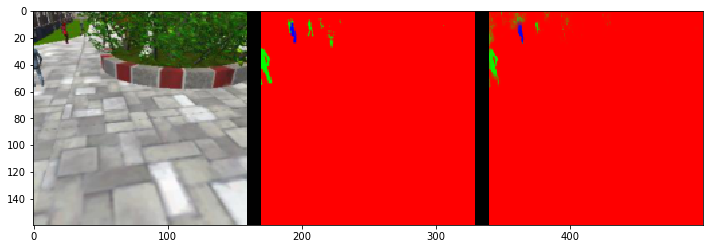

In [18]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('test', 'patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [19]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9956939655364254
average intersection over union for other people is 0.3650452268104623
average intersection over union for the hero is 0.9164519779788426
number true positives: 539, number false positives: 0, number false negatives: 0


In [20]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9886143192840604
average intersection over union for other people is 0.7660309207841813
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 46, number false negatives: 0


In [21]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.996238268052201
average intersection over union for other people is 0.4431771161786138
average intersection over union for the hero is 0.2718878086112758
number true positives: 159, number false positives: 3, number false negatives: 142


In [22]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7851518560179978


In [23]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.594169893295


In [24]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.466513594511


In [24]:
# Now we will plot the graph created:
plotting_tools.plot_keras_model(model, "Graph")

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))